Checking if there is a GPU device available for training. I did the training on Kaggle, so this is just to debug.

In [1]:
kaggle = True
if kaggle:
    !pip install d2l;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 73.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 82.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 98.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 53.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.2
    Uninstalling pyparsing-3.1.2:
      Successfully uninstalled pyparsing-3.1.

In [2]:
import torch

print("CUDA Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

CUDA Available: True
Device Name: Tesla T4


In [3]:
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from d2l import torch as d2l
import os
import pandas as pd

## Below I define:
- A custom Test Dataset class to make the test dataloader
- The network architecture (to be changed and modified further)
- A custom Data class to be passed into the trainer.fit() method later

In [4]:
class TestDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [
            os.path.join(root, fname)
            for fname in os.listdir(root)
            if fname.endswith(('jpg', 'png', 'jpeg'))
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_path

def init_cnn(module):
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear) or isinstance(module, nn.LazyConv2d) or isinstance(module, nn.LazyLinear):
        nn.init.xavier_uniform_(module.weight)

class NandNet(d2l.Classifier):
    def __init__(self, numchannels, lr=0.1, num_classes=2):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=3, stride=1, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.LazyConv2d(6, kernel_size=3, stride=1, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.LazyConv2d(6, kernel_size=3, stride=1, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.LazyConv2d(6, kernel_size=3, stride=1, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            nn.LazyConv2d(6, kernel_size=3, stride=1, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.Flatten(), nn.LazyLinear(256), nn.LazyBatchNorm1d(),
            nn.ReLU(), nn.LazyLinear(64), nn.LazyBatchNorm1d(),
            nn.ReLU(), nn.LazyLinear(num_classes), nn.Softmax(dim=1)
        )
        
        self.best_loss = float('inf')
        self.best_acc = 0
    
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        l = self.loss(Y_hat, batch[-1])
        a = self.accuracy(Y_hat, batch[-1])
        if l < self.best_loss:
            self.best_loss = l
        if a > self.best_acc:
            self.best_acc = a
        self.plot('loss', l, train=False)
        self.plot('acc', a, train=False)

        

class MyData(d2l.DataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        self.train = trainset
        self.val = valset
        self.batch_size = batch_size
        

    def text_labels(self, indices):
        labels = ["yes", "no"]
        return [labels[int(i)] for i in indices]

    def get_dataloader(self, train):
        data = self.train if train else self.val
        return DataLoader(data, self.batch_size, shuffle=train, num_workers=4)

    def visualize(self, batch, nrows=1, ncols=8, labels=None):
        if labels is None:
            labels = []
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)

## Below I define:
- The transformations to apply to our data in order to augment it
- The variables that hold the training, validation, and test sets

In [16]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(
        size=224,
        scale=(0.85, 1.15),
        ratio=(0.75, 1.33)
    ),
    transforms.ToTensor(),
])

data_path = '/kaggle/input/kagglechallengedata/dl2425_challenge_dataset' if kaggle else 'dl2425_challenge_dataset'

trainset = datasets.ImageFolder(
    root = data_path + '/train',
    transform = transform
)
valset = datasets.ImageFolder(
    root = data_path + '/val',
    transform = transform
)
testset = TestDataset(
    root = data_path + '/test',
    transform = transform
)

testloader = DataLoader(testset, batch_size=32, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = NandNet(numchannels=9, lr=0.1, num_classes=2).to(device)
#model.layer_summary((32, 3, 224, 224))
#model = model.to(device)
#trainer = d2l.Trainer(max_epochs=12, num_gpus=1)
#dummy_input = torch.randn(32, 3, 224, 224).to(device)
#model(dummy_input)
#model.apply(init_cnn)
data = MyData(batch_size=32)
rs18 = models.resnet18(pretrained=True)
rs18.fc = nn.Linear(rs18.fc.in_features, 2)
nn.init.xavier_uniform_(rs18.fc.weight);


Linear(in_features=512, out_features=2, bias=True)


In [22]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = data.get_dataloader(train=True)
    test_iter = data.get_dataloader(train=False)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

## Below I define:
- The code to train the model
- (If ran in a Jupyter Notebook cell, it also outputs a dynamic train-acc graph)

loss 0.090, train acc 0.969, test acc 0.984
406.1 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


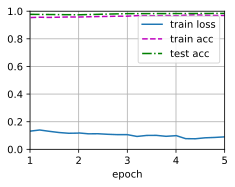

In [23]:
if __name__ == '__main__':

    train_fine_tuning(rs18, 5e-5)
    #trainer.fit(model, data)
    #print(model.best_loss, model.best_acc)
    #torch.save(model.state_dict(), '5_layer_monster.pth')

## Below I define:
- The model that is to be loaded from the models directory
- The test loop
- The results Data Frame which takes multiple dictionaries in the form {id: class} and converts them into cells in a .csv file
- Saves the predictions.csv file to desired path (this is what we will submit)

In [29]:
device = torch.device("cuda")
model = NandNet(numchannels=12, lr=0.1, num_classes=1)
current_model = '/kaggle/working/4l_var-chnl_256-64_maxpool2_tinylr.pth'
model.load_state_dict(torch.load(current_model))
model = model.to(device)
model.eval()

results = []

with torch.no_grad():
    for images, paths in testloader:
        images = images.to(device)
        outputs = model(images)
        
        probabilities = torch.softmax(outputs, dim=1)
        predictions = torch.argmax(probabilities, dim=1) 

        for path, pred in zip(paths, predictions.cpu().numpy()):
            filename = os.path.basename(path) 
            results.append({"id": filename, "class": int(pred)})

# save model predictions!!
results = sorted(results, key = lambda x: int(x["id"].replace(".jpg", "")))
df = pd.DataFrame(results)
df.to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'")

/tmp/ipykernel_30/78155334.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(current_model))


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/4l_var-chnl_256-64_maxpool2_tinylr.pth'

## Next steps:
- Make the model better
- Utilize as few pre made d2l methods as possible
- Once we are confident in our prediction results, merge (labeled) test, train, and val
- Train the final model on all of it